In [66]:
import sys
sys.path.insert(1, '../../eispy2d/library/')
import numpy as np
from skimage import measure
from matplotlib import pyplot as plt
import inputdata as ipt
import result as rst
import configuration as cfg

Pressupostos:
* Função contraste (mapa) não seja uma função diferenciável (superfície).
* O algoritmo de reconstrução consegue discenir razoavelmente as bordas.
* No caso de múltiplos espalhadores com diferentes níveis de contraste, os menores níveis de constraste não estão abaixo da metade da diferença entre objeto de maior contraste e o fundo (**não ter contraste menor que zero**).
* Objetos de constraste diferentes não estejam sobrepostos (senão serão considerados como um objeto só).

Carregando os arquivos de teste e de resultado de reconstrução.

In [67]:
test = ipt.InputData(import_filename='test.ipt', import_filepath='./data/')
reconstruction = rst.Result(import_filename='test-osm.rst', 
                            import_filepath='./data/')

Obtendo a imagem de contraste. Quando permissividade e condutividade são consideradas simultaneamente, o contraste tem parte real e imaginária. Para que seja independente disso, a metodologia de avaliação é calculada com base no módulo do contraste. Porque, assim, até quando objetos tiverem mesma permissividade e condutividades diferentes, vai ser possível diferenciar os dois. O que não quer dizer que objetos com propriedades diferentes e mesmo módulo sejam possíveis de serem confundidos. Mas é menos provável.

In [68]:
# Obtém imagem de contraste do valor original e reconstruído
chi_o = cfg.get_contrast_map(epsilon_r=test.rel_permittivity,
                             configuration=test.configuration)
chi_r = cfg.get_contrast_map(epsilon_r=reconstruction.rel_permittivity,
                             configuration=test.configuration)

# Calcula o módulo de ambos
Xo, Xr = np.abs(chi_o), np.abs(chi_r)

É muito comum que, nas imagens reconstruídas pelos algoritmos, o constraste seja como uma função suave (diferenciável). Logo, não costuma haver um fundo com valor constante. Além disso, não costuma haver uma separação bem definida entre fundo e objetos, sendo assim necessário adotar algum limiar que sirva de paramêtro para separar objeto e fundo nas imagens reconstruídas. *Quanto mais o algoritmo for eficiente, mais as bordas vão ser rápidas e menor a influência desse parâmetro.* Só em casos de algoritmos que *não conseguem discenir muito bem as bordas* que esse parâmetro pode prejudicar ou não a avaliação desta característica. Isto daqui pode dar problema quando houverem **múltiplos objetos com diferentes valores de contraste, sendo o menor contraste próximo do fundo**. Aí esse objeto fica despercebido.

Esse limiar é como se fosse para ser o valor máximo de flutuação no fundo também.

In [69]:
# Define limiar
threshold = (np.amin(np.abs(Xr)) + .5*(np.amax(np.abs(Xr))-np.amin(np.abs(Xr))))
print(f"Threshold: {threshold}")

Threshold: 0.5


Com esse limiar, a gente pode aplicar um limiarizador da imagem porque, como o objetivo é evitar influência da estimativa de contraste, podemos tratar a imagem binariamente.

No caso de objetos homogêneos sobrepostos, o algoritmo não vai detectar as diferenças, vai ser tudo encarado como um objeto só. Mesmo se eu não fizesse a limiarização, já seria assim por causa do algoritmo do ```measure.find_contours```.

In [70]:
# Limiariza as imagens
Xo[Xo > 0] = 1
Xr[Xr <= threshold] = 0
Xr[Xr > threshold] = 1

Se não tiver nenhum pixel acima do limiar na imagem reconstruída, ou seja, tudo fundo, então pode já retornar o erro em 100%.

In [71]:
# Se não tiver nenhum objeto, o erro é 100%.
if np.sum(Xr) == 0:
    # return 100.
    pass

Em seguida, é necessário detectar os contornos dos objetos:

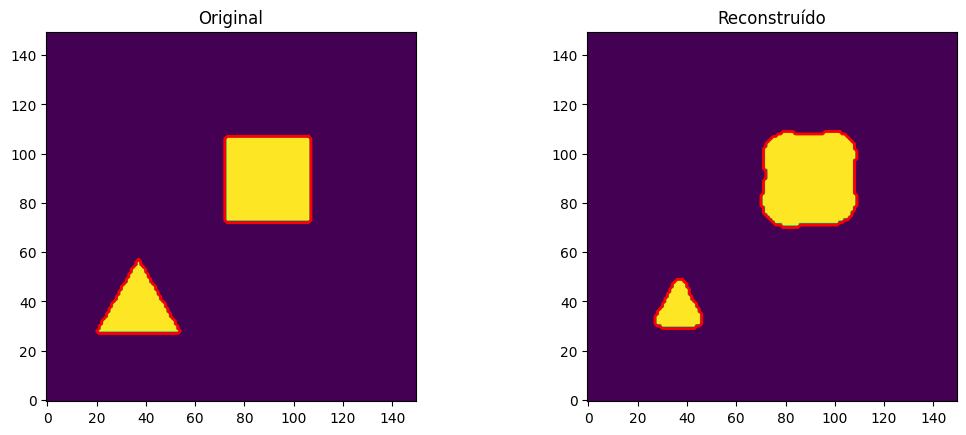

In [72]:
# Determina os contornos
co = measure.find_contours(Xo, .0, fully_connected='high')
cr = measure.find_contours(Xr, 0, fully_connected='high')

fig, axis = plt.subplots(ncols=2, figsize=(2*6.4, 4.8))
axis[0].imshow(Xo, origin='lower')
for contour in co:
    axis[0].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
axis[0].set_title('Original')
axis[1].imshow(Xr, origin='lower')
for contour in cr:
    axis[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
axis[1].set_title('Reconstruído')
plt.show()

Nesse caso, não é problema. Mas quando as imagens tem números de pixels diferente, então as coordenadas dos contornos ficam diferentes. Por isso, é necessário padronizar essas coordenadas de acordo com a imagem original. As imagens podem permanecer em resoluções diferentes.

In [73]:
# Converte as coordenadas dos contornos para as dimensões da imagem original.
# As coordenadas estão no intervalo dos número de pixels da imagem original.
for i in range(len(cr)):
    cr[i][:, 1] = Xo.shape[1]*cr[i][:, 1]/Xr.shape[1]
    cr[i][:, 0] = Xo.shape[0]*cr[i][:, 0]/Xr.shape[0]

Para remover a influência de erro de posicionamento, é necessário construir a malha de coordenadas e calcular o centro dos objetos. Quando só tem um objeto na imagem (mesmo que vazado), o ponto central é o ponto do objeto em si. No caso de múltiplos objetos, o ponto é considerando o sistema como um todo.

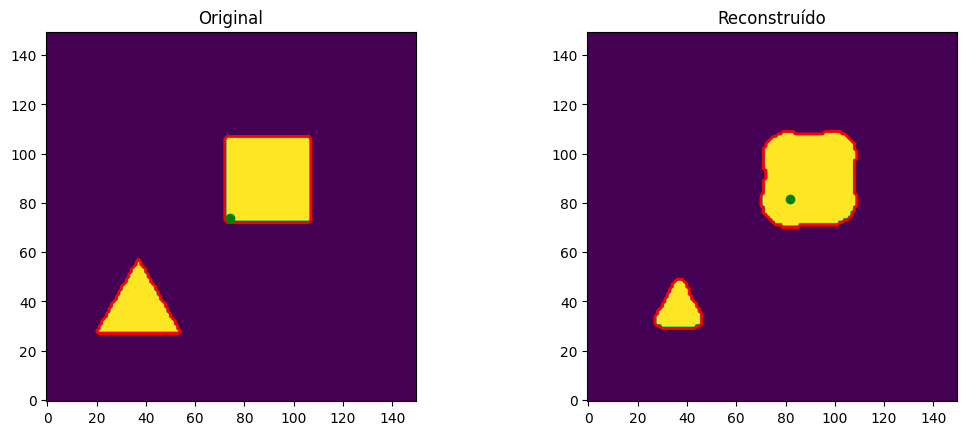

In [74]:
# Coordenadas dos pixels da imagem original e reconstruída.
xo, yo = np.meshgrid(np.arange(0, Xo.shape[1]), np.arange(0, Xo.shape[0]))
xr, yr = np.meshgrid(np.linspace(0, Xo.shape[1]-1, Xr.shape[1]),
                     np.linspace(0, Xo.shape[0]-1, Xr.shape[0]))

# Calcula os pontos centrais
xco = np.sum(Xo*xo)/np.sum(Xo)
yco = np.sum(Xo*yo)/np.sum(Xo)
xcr = np.sum(Xr*xr)/np.sum(Xr)
ycr = np.sum(Xr*yr)/np.sum(Xr)

fig, axis = plt.subplots(ncols=2, figsize=(2*6.4, 4.8))
axis[0].imshow(Xo, origin='lower')
for contour in co:
    axis[0].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
axis[0].plot(xco, yco, 'o', color='green')
axis[0].set_title('Original')
axis[1].imshow(Xr, origin='lower')
for contour in cr:
    axis[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
axis[1].plot(xcr, ycr, 'o', color='green')
axis[1].set_title('Reconstruído')
plt.show()

Eu não vou fazer a questão de olhar objeto por objeto porque isso precisa de uma lógica de casamento de contornos, ou seja, eu precisava identificar contorno é de cada coisa. E isso é mais difícil no caso de objetos vazados, porque é mais de um contorno.

Então, depois de calcular o centro, eu posiciono os contornos no centro da imagem através da distância entre o centro da imagem com o ponto central dos objetos.

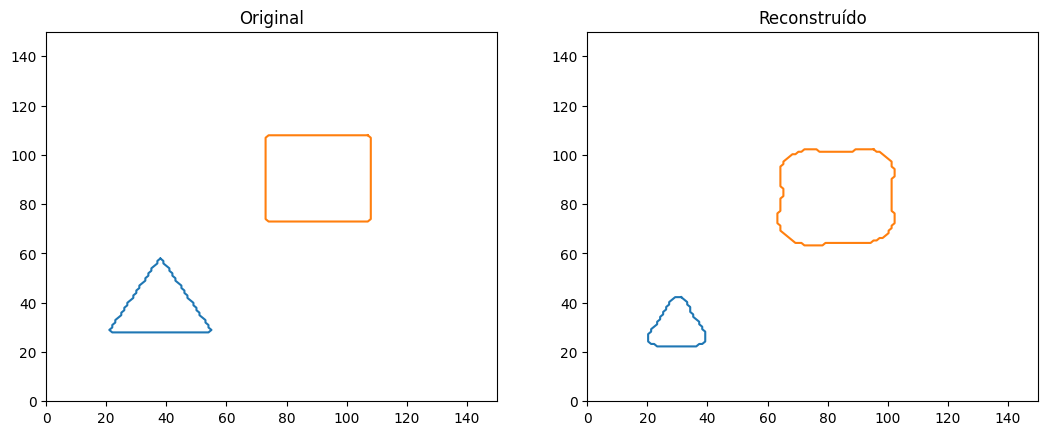

In [75]:
fig, axis = plt.subplots(ncols=2, figsize=(2*6.4, 4.8))

# Joga os contornos para o centro da imagem.
for i in range(len(co)):
    co[i][:, 0] = co[i][:, 0]-yco+Xo.shape[0]/2
    co[i][:, 1] = co[i][:, 1]-xco+Xo.shape[1]/2
    axis[0].plot(co[i][:, 1], co[i][:, 0])
axis[0].set_title('Original')
axis[0].set_xlim(0, Xo.shape[1])
axis[0].set_ylim(0, Xo.shape[0])

# Joga os contornos para o centro da imagem.
for i in range(len(cr)):
    cr[i][:, 0] = cr[i][:, 0]-ycr+Xo.shape[0]/2
    cr[i][:, 1] = cr[i][:, 1]-xcr+Xo.shape[1]/2
    axis[1].plot(cr[i][:, 1], cr[i][:, 0])
axis[1].set_title('Reconstruído')
axis[1].set_xlim(0, Xr.shape[1])
axis[1].set_ylim(0, Xr.shape[0])
plt.show()

Agora, é necessário ter imagens de igual resolução para calcularmos o indicador. Então, pegamos uma imagem vazia e adicionamos os pontos dentro do contorno em formato boolean.

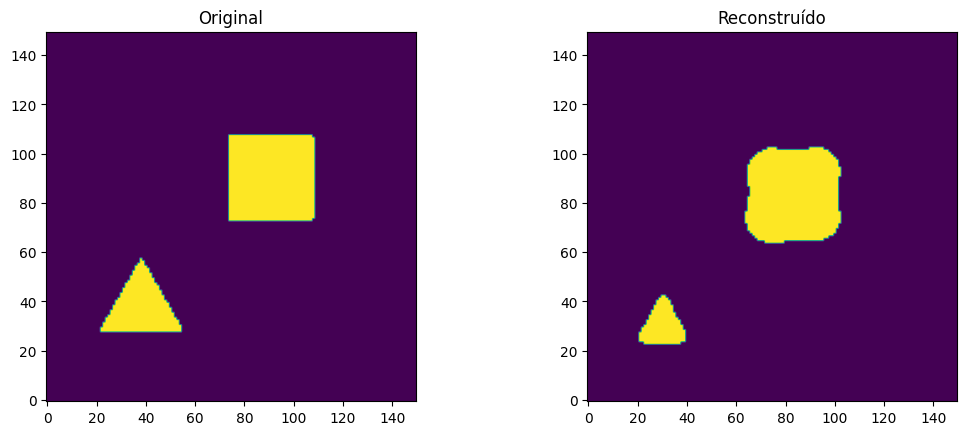

In [76]:
masko = np.zeros(Xo.shape, dtype=bool)
counter = np.zeros(Xo.shape)
for i in range(len(co)):
    maskt = measure.grid_points_in_poly(Xo.shape, co[i])
    counter[maskt] += 1
masko[np.mod(counter, 2) == 1] = True # Para corrigir quando se tem buracos

maskr = np.zeros(Xo.shape, dtype=bool)
counter = np.zeros(Xo.shape)
for i in range(len(cr)):
    maskt = measure.grid_points_in_poly(Xo.shape, cr[i])
    counter[maskt] += 1
maskr[np.mod(counter, 2) == 1] = True # Para corrigir quando se tem buracos

fig, axis = plt.subplots(ncols=2, figsize=(2*6.4, 4.8))
axis[0].imshow(masko, origin='lower')
axis[0].set_title('Original')
axis[1].imshow(maskr, origin='lower')
axis[1].set_title('Reconstruído')
plt.show()

Em seguida calculamos a diferença, ou seja, os falsos-positivos e falsos-negativos da imagem.

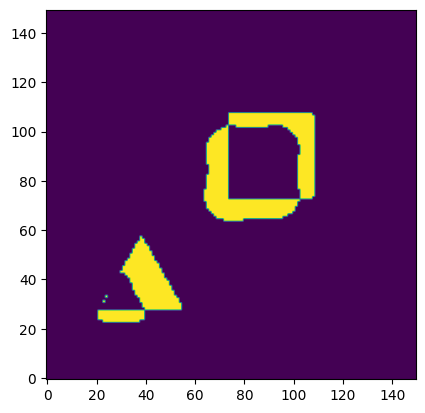

In [77]:
# Xor operation
diff = np.logical_xor(masko, maskr)

plt.imshow(diff, origin='lower')
plt.show()

Note que o deslocamento, cujo o objetivo era tirar a influência do erro de posicionamento, faz aparecer muito mais diferenças. Por isso, o erro vai ser maior. Então eu vou tirar isso do código oficial, até porque posionamento nem é algo tão problemático nos algoritmos.

O indicador vai ser uma porcentagem que reflete a soma dos erros falso-positivo com falso-negativo em relação ao total de pixels da imagem original. Por isso, pode ser mais que 100%.

In [87]:
# Area of the difference
area_diff = np.sum(diff)/np.sum(masko)*100
print(f"Erro de forma: {area_diff} %")

Erro de forma: 79.69195664575014 %


Se removermos essa etapa de centralização:

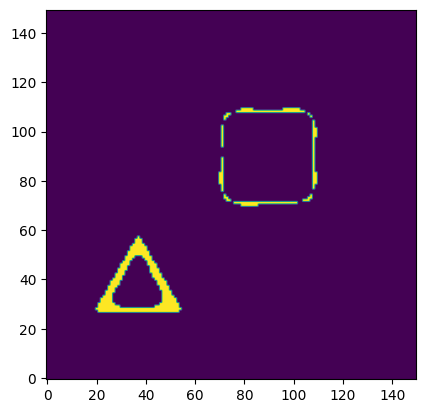

Erro de forma: 24.13055109684323 %


In [88]:
# Determina os contornos
co = measure.find_contours(Xo, .0, fully_connected='high')
cr = measure.find_contours(Xr, 0, fully_connected='high')

# Converte as coordenadas dos contornos para as dimensões da imagem original.
# As coordenadas estão no intervalo dos número de pixels da imagem original.
for i in range(len(cr)):
    cr[i][:, 1] = Xo.shape[1]*cr[i][:, 1]/Xr.shape[1]
    cr[i][:, 0] = Xo.shape[0]*cr[i][:, 0]/Xr.shape[0]

masko = np.zeros(Xo.shape, dtype=bool)
counter = np.zeros(Xo.shape)
for i in range(len(co)):
    maskt = measure.grid_points_in_poly(Xo.shape, co[i])
    counter[maskt] += 1
masko[np.mod(counter, 2) == 1] = True # Para corrigir quando se tem buracos

maskr = np.zeros(Xo.shape, dtype=bool)
counter = np.zeros(Xo.shape)
for i in range(len(cr)):
    maskt = measure.grid_points_in_poly(Xo.shape, cr[i])
    counter[maskt] += 1
maskr[np.mod(counter, 2) == 1] = True # Para corrigir quando se tem buracos

# Xor operation
diff = np.logical_xor(masko, maskr)

plt.imshow(diff, origin='lower')
plt.show()

# Area of the difference
area_diff = np.sum(diff)/np.sum(masko)*100
print(f"Erro de forma: {area_diff} %")